# Group 2 Project: Used Cars

## Link to dataset on Kaggle: [Used Cars Dataset](https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data)

## Description to run the notebook:

#### The link given above directly leads to the kaggle website where we have our dataset, download the file as a zip and extract an unzipped version . From there, upload the vehicles.csv file into the same folder which holds our project. Our csv reader assumes that the file is directly accessible from the same folder, and needs to see it, otherwise it'll throw an error. (NOTE: Our dataset has approximately 450,000 entries, so the file is 1.4 Gigabytes and will take some time to download and read).

In [1]:
import math
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from typing import Dict
import csv
from typing import NamedTuple
from scipy.spatial import distance
from collections import defaultdict
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
Vector = List[float]
pd.options.mode.chained_assignment = None 

In [2]:
# The car dataset in its original form before any testing
original = pd.read_csv("vehicles.csv", engine = "python", encoding = "latin1")

In [3]:
#########
#Extracting the input features from the original dataset
usedcars = original[["price", "year", "manufacturer", "condition", "cylinders", "odometer", "title_status", "transmission", "drive", "type"]]
#########

In [4]:
#Consider only values which don't have a null value
newUsedCars = usedcars.dropna()

#Find outliers within the dataset to reduce extremeities and skewness
def find_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df.drop(df[(df[column] < lower_bound)].index, inplace = True)
    df.drop(df[(df[column] > upper_bound)].index, inplace = True)
    
find_outliers_iqr(newUsedCars, 'price')
find_outliers_iqr(newUsedCars, 'odometer')
find_outliers_iqr(newUsedCars, 'year')

##Turns string to int value for relevant input features
le = LabelEncoder()
newUsedCars['conditionint'] = le.fit_transform(newUsedCars['condition'])
newUsedCars["title_statusint"] = le.fit_transform(newUsedCars["title_status"])
newUsedCars["transmissionint"] = le.fit_transform(newUsedCars["transmission"])
newUsedCars["manufacturerint"] = le.fit_transform(newUsedCars["manufacturer"])
newUsedCars["cylindersint"] = le.fit_transform(newUsedCars["cylinders"])
newUsedCars["driveint"] = le.fit_transform(newUsedCars["drive"])
newUsedCars["typeint"] = le.fit_transform(newUsedCars["type"])

## Bar Charts for categorical variables and their mean prices

<Axes: title={'center': 'Prices by Condition'}, xlabel='condition'>

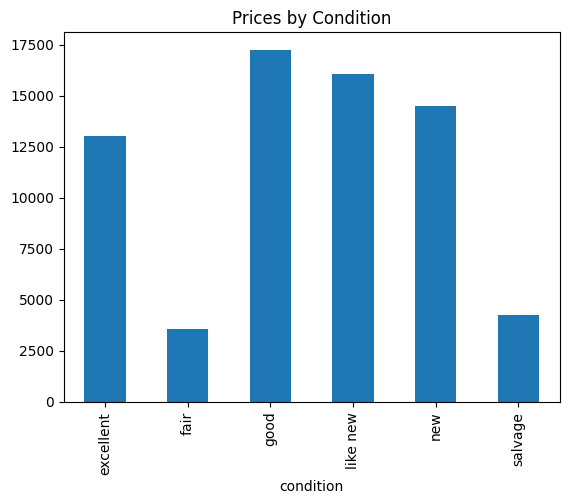

In [5]:
newUsedCars.groupby(["condition"])["price"].mean().plot(kind="bar", title="Prices by Condition")

#### As seen by this graph, the mean value of a car generally decreases as its condition gets worse, though one exception are cars in "good" condition, which has a slightly higher mean price than the other categories. This could be the result of most of the cars in the dataset having the "good" condition applied to them compared to the others

<Axes: title={'center': 'Prices by Car Status'}, xlabel='title_status'>

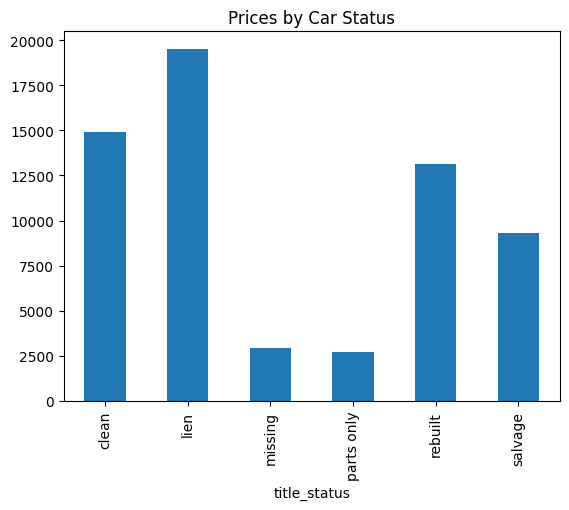

In [6]:
newUsedCars.groupby(["title_status"])["price"].mean().plot(kind="bar", title="Prices by Car Status")

#### The results from this graph are as expected, with cars that are more complete and finished being more valuable. Cars with a lien status ont hem are sold off at even higher prices than the rest, though the means are still closer together

<Axes: title={'center': 'Prices by Transmission Type'}, xlabel='transmission'>

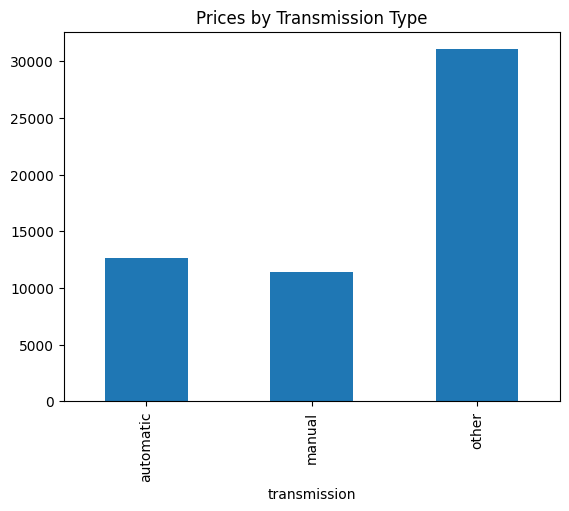

In [7]:
newUsedCars.groupby(["transmission"])["price"].mean().plot(kind="bar", title="Prices by Transmission Type")

#### There isn't much difference between the mean prices of the types of transmissions, though cars with alternative transmissions are more valuable overall.

<Axes: title={'center': 'Prices by Manufacturer'}, xlabel='manufacturer'>

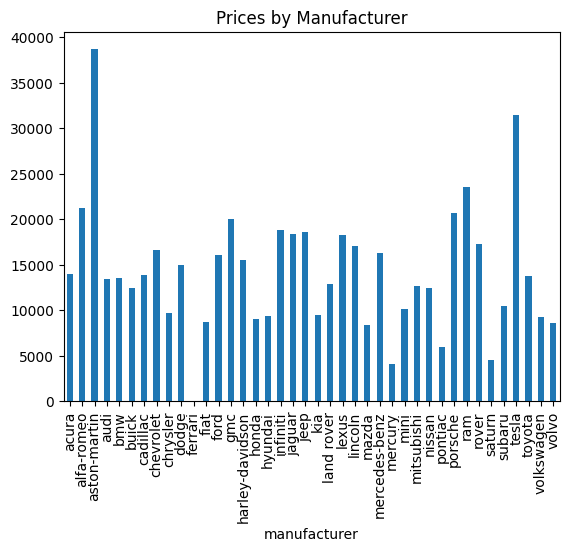

In [8]:
newUsedCars.groupby(["manufacturer"])["price"].mean().plot(kind="bar", title="Prices by Manufacturer")

#### There are strong differences among the mean prices of cars by their manufacutrer. Generally more high-class manufactuers like Alfa-Romeo and Aston-Martin are far more valuable than more general car manufacturers like Chevrolet and Ford.

<Axes: title={'center': 'Prices by Number of Cylinders'}, xlabel='cylinders'>

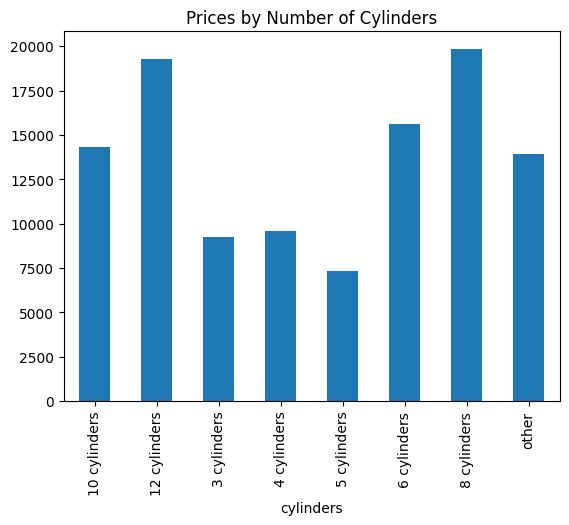

In [9]:
newUsedCars.groupby(["cylinders"])["price"].mean().plot(kind="bar", title="Prices by Number of Cylinders")

#### Though both 10-cylinder and 5-cylinder cars break from this trend, the mean price of a car generally increases as the number of cylinders increases giving a somewhat linear relationship between cylinders and prices.

<Axes: title={'center': 'Prices by Their Type of Drive'}, xlabel='drive'>

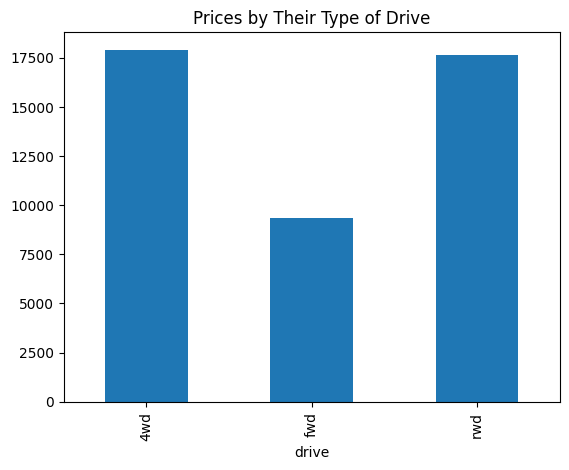

In [10]:
newUsedCars.groupby(["drive"])["price"].mean().plot(kind="bar", title="Prices by Their Type of Drive")

#### Cars which have a forward wheel drive have far lower mean prices than cars with a rear wheel or 4 wheel drive

<Axes: title={'center': 'Prices by the type of car'}, xlabel='type'>

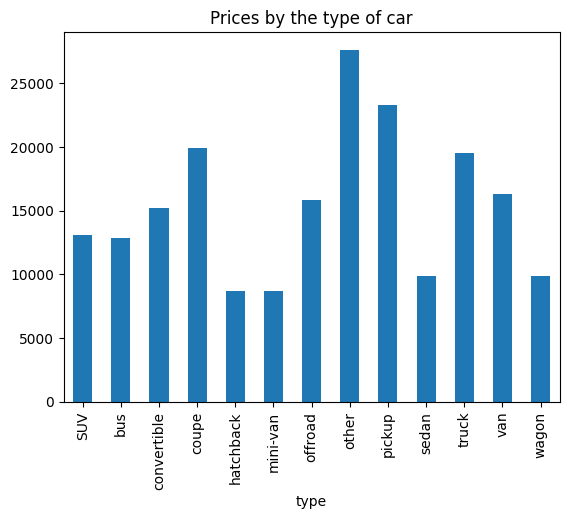

In [11]:
newUsedCars.groupby(["type"])["price"].mean().plot(kind="bar", title="Prices by the type of car")

#### Mean prices differ heavily based on what type a specific car is, ranging from hatchbacks and mini-vans to coupes and pickups, the differences in types should be a good indicator of a specific car's value.

## Scatterplots for relationship between quantitative variables and car prices

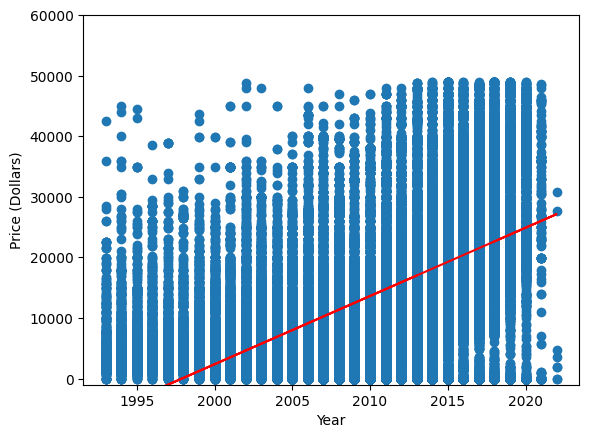

In [12]:
#Setting up a scatter plot between the year and the price
fig, ax = plt.subplots()
year = newUsedCars["year"]
price = newUsedCars["price"]
ax.scatter(year, price)

# Creating a regression line to show the trend

m, b = np.polyfit(year, price, deg=1)
ax.plot(year, m * year + b, color="red")

#labels
plt.xlabel("Year")
plt.ylabel("Price (Dollars)")

# setting the limits to make it easy to view
plt.ylim(-1000, 60000)
plt.show()
#plt.xlim(1900, 2022)

#### Looking at this graph, there seems to be a slightly positive relationship between the year and the price. There is a strong positve linear relationship between the age of a car and its price, showing that age is a good indicator of price and a valuable input for our model.

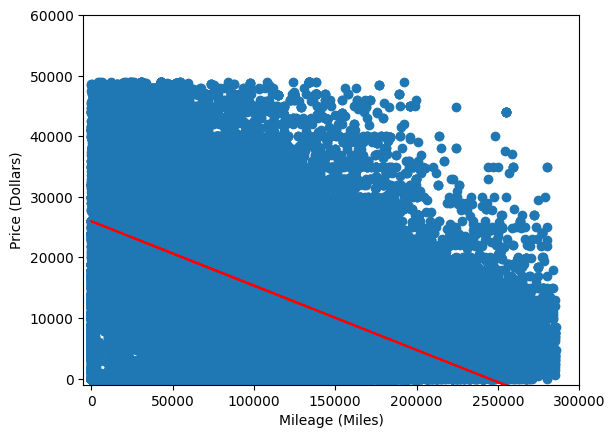

In [13]:
#Setting up a scatter plot between the mileage and the price
fig, ax = plt.subplots()
mileage = newUsedCars["odometer"]
price = newUsedCars["price"]

#plotting the line
ax.scatter(mileage, price)

# Creating a regression line to show the trend
m, b = np.polyfit(mileage, price, deg=1)
ax.plot(mileage, m * mileage + b, color="red")

#labels
plt.xlabel("Mileage (Miles)")
plt.ylabel("Price (Dollars)")

# setting the limits to make it easy to view
plt.ylim(-1000, 60000)
plt.xlim(-5000, 300000)
plt.show()

#### Unlike the relationship between the year and the price, the relationship between the mileage of a car and its price is negative, meaning that the more a car has been driven, the lower its price becomes. The strongly downward sloping nature of the regression line means mileage is a valuable metric to judge a car's price

## Heat Map of Correlations

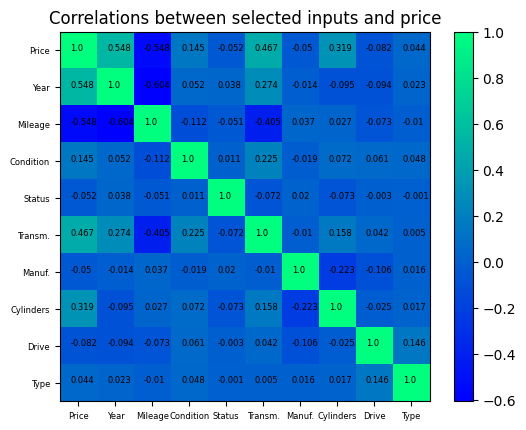

In [14]:

#Correlating each relevant category with others
correlations = newUsedCars[["price", "year", "odometer", "conditionint", "title_statusint", "transmissionint", "manufacturerint", "cylindersint", "driveint", "typeint"]].corr()
#Setting the axes up (Transm. = Transmission and Manuf. = Manufacturer, reduced to avoid word overlap)
ax = plt.axes()
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xticklabels(["Price", "Year", "Mileage", "Condition", "Status", "Transm.", "Manuf.", "Cylinders", "Drive", "Type"], fontsize = 6)
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_yticklabels(["Price", "Year", "Mileage", "Condition", "Status", "Transm.", "Manuf.", "Cylinders", "Drive", "Type"], fontsize = 6)

#Setting the title
plt.title("Correlations between selected inputs and price")
plt.imshow(correlations, cmap="winter")
plt.colorbar()
#Putting the actual correlation coefficients with their respective correlation
for i in range(10):
    for j in range(10):
        plt.annotate(str(round(correlations.values[i][j], 3)), xy=(j - 0.225, i), fontsize=6)

#### The correlation matrix shows which inputs have the most impact on price and, as a result, which inputs will be the most valuable to improving our dataset. Variables with a higher absolute correlation, like the Year and Mileage, have a far greater impact on predictions than less correlative variables like the Status and Manufacturer of the car

## Box Plot for price

Text(0.5, 1.0, 'Boxplot for the price of used cars')

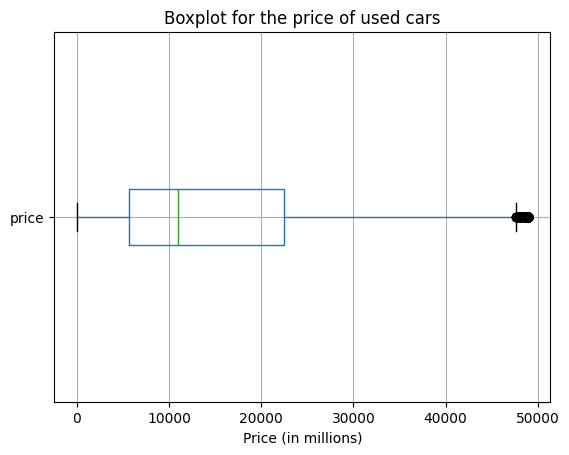

In [15]:
newUsedCars.boxplot(column=["price"], vert=False, xlabel="Price (in millions)")
plt.title("Boxplot for the price of used cars")

#### As shown by the boxplot, when major outliers are removed from the data set, the price of most cars tends to sit in the 10,000 to 20,000 dollar range. The data is somewhat skewed right, but not to a troubling extent that can get in the way of accurate testing.

## Quadratic Regression testing (Roshan)

#### In order to observe the impacts that removing inputs have on a quadratic regression model, I'll run two tests. One test will use all inputs and one will use inputs whose correlation is greater than 0.250, regardless of sign. These 4 inputs are:
* Year
* Mileage
* Transmission Type
* Number of Cylinders
#### With the previous testing I had done on this model, the reduced number of inputs should cause a lower R-squared value, as Quadratic Regression seems to get more accurate the more inputs are given to the model

### All Inputs

In [16]:
#The inputs to predict the price
Inputs = newUsedCars[["year", "odometer", "conditionint", "title_statusint", "transmissionint", "manufacturerint", "cylindersint", "driveint", "typeint"]]
#Price, the output
Price = newUsedCars["price"]
#Splitting the dataset into 80% training and 20% testing
trainerX, testerX, trainerY, testerY = train_test_split(Inputs, Price, test_size=0.2, random_state=27)
 

In [17]:
## Quadratic Regression Model

PolyRegress = PolynomialFeatures(2)
polyFTrainer = PolyRegress.fit_transform(trainerX)
polyFTester = PolyRegress.fit_transform(testerX)
polyM = linear_model.LinearRegression()
polyM.fit(polyFTrainer, trainerY)
trainerYPredictions = polyM.predict(polyFTrainer)
testerYPredictions = polyM.predict(polyFTester)


#### Evaluation

In [18]:
print(f'Root mean squared error: {root_mean_squared_error(testerYPredictions, testerY)}')
print(f'Mean absolute error: {mean_absolute_error(testerYPredictions, testerY)}')
#print(f'Correlation coefficients: {polyM.coef_}')
print(f'R-Squared: {r2_score(testerYPredictions, testerY)}')

Root mean squared error: 7087.184406348763
Mean absolute error: 4662.886268516743
R-Squared: 0.42787469029989667


### Four Best Inputs

In [19]:
#The inputs to predict the price
Inputs = newUsedCars[["year", "odometer", "transmissionint", "cylindersint"]]
#Price, the output
Price = newUsedCars["price"]
#Splitting the dataset into 80% training and 20% testing
trainerX, testerX, trainerY, testerY = train_test_split(Inputs, Price, test_size=0.2, random_state=27)

In [20]:
## Quadratic Regression Model

PolyRegress = PolynomialFeatures(2)
polyFTrainer = PolyRegress.fit_transform(trainerX)
polyFTester = PolyRegress.fit_transform(testerX)
polyM = linear_model.LinearRegression()
polyM.fit(polyFTrainer, trainerY)
trainerYPredictions = polyM.predict(polyFTrainer)
testerYPredictions = polyM.predict(polyFTester)

#### Evaluation

In [21]:
print(f'Root mean squared error: {root_mean_squared_error(testerYPredictions, testerY)}')
print(f'Mean absolute error: {mean_absolute_error(testerYPredictions, testerY)}')
#print(f'Correlation coefficients: {polyM.coef_}')
print(f'R-Squared: {r2_score(testerYPredictions, testerY)}')

Root mean squared error: 7470.031168839798
Mean absolute error: 4936.45576610675
R-Squared: 0.32410562748101035


## Conclusions

#### As was expected, the reduction in the number of inputs, even when including only the best ones, causes the accuracy of the model to drop significantly
* Even inputs with lower correlation values can still contribute to greater accuracy
* Due to the low degree of the model, the risk of overfitting wasn't faced, even when adding more inputs
* Despite the number of inputs given to the model, it still wasn't able to get an R-squared value above 0.5